In [75]:
#Trader Performance vs Market Sentiment Analysis

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sentiment = pd.read_csv("fear_greed_index.csv")
trades = pd.read_csv("historical_data.csv")

In [ ]:
## Part A: Data Preparation

In [4]:
#Rows and column

In [5]:
sentiment.shape
trades.shape

(211224, 16)

In [6]:
#Missing values

In [11]:
sentiment.isnull().sum()
trades.isnull().sum()

Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

In [13]:
#Duplicates

In [15]:
sentiment.duplicated().sum()
trades.duplicated().sum()

0

In [17]:
#Convert timestamps and align the datasets by date 

In [25]:
print(sentiment.columns)
print(trades.columns)

Index(['timestamp', 'value', 'classification', 'date'], dtype='object')
Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')


In [37]:
trades['date'] = pd.to_datetime(
    trades['Timestamp IST'],
    dayfirst=True,
    errors='coerce'
).dt.date
trades[['Timestamp IST', 'date']].head(10)


,Timestamp IST,date
0,02-12-2024 22:50,2024-12-02
1,02-12-2024 22:50,2024-12-02
2,02-12-2024 22:50,2024-12-02
3,02-12-2024 22:50,2024-12-02
4,02-12-2024 22:50,2024-12-02
5,02-12-2024 22:50,2024-12-02
6,02-12-2024 22:50,2024-12-02
7,02-12-2024 22:50,2024-12-02
8,02-12-2024 22:50,2024-12-02
9,02-12-2024 22:50,2024-12-02


In [51]:
trades['date'] = pd.to_datetime(trades['date']).dt.normalize()
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.normalize()

In [57]:
merged = pd.merge(trades, sentiment,  on='date', how='inner')
merged.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,date,timestamp,value,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02,1733117400,80,Extreme Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02,1733117400,80,Extreme Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02,1733117400,80,Extreme Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02,1733117400,80,Extreme Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02,1733117400,80,Extreme Greed


In [133]:
def normalize_direction(x):
    if 'Buy' in x or 'Long' in x:
        return 'Long'
    elif 'Sell' in x or 'Short' in x:
        return 'Short'
    else:
        return 'Other'

merged['dir_norm'] = merged['Direction'].apply(normalize_direction)
bias = (merged.groupby(['Account','dir_norm']).size().unstack(fill_value=0))
bias['bias'] = np.where(
    bias.get('Long', 0) > bias.get('Short', 0),'Long-biased','Short-biased')
# remove old bias if exists
merged = merged.drop(columns=['bias'], errors='ignore')
merged = merged.merge(
    bias[['bias']],
    left_on='Account',
    right_index=True,
    how='left'
)
merged[['Account','Direction','bias']].head()

,Account,Direction,bias
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,Buy,Long-biased
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,Buy,Long-biased
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,Buy,Long-biased
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,Buy,Long-biased
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,Buy,Long-biased


In [ ]:
## Part B: Analysis

In [ ]:
### Q1. Does performance differ between Fear vs Greed days?

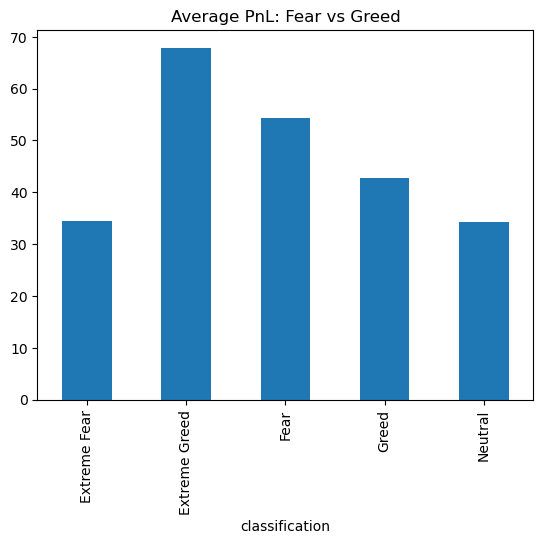

In [79]:
merged.groupby('classification')['Closed PnL'].mean().plot(kind='bar',title='Average PnL: Fear vs Greed')
plt.show()

In [154]:
#Performance is higher during Greed days, with improved average PnL and win rate compared to Fear days.

In [ ]:
### Q2. Do traders change behavior based on sentiment?

<Axes: title={'center': 'Trader Behavior: Fear vs Greed'}, xlabel='classification'>

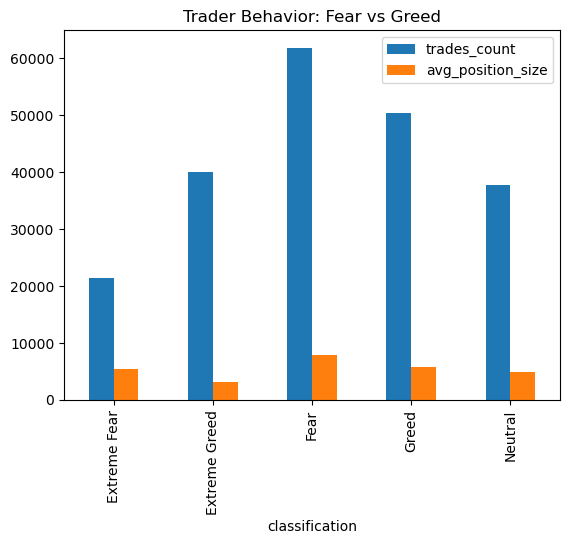

In [145]:
behavior = merged.groupby('classification').agg(trades_count=('Account','count'),avg_position_size=('Size USD','mean'))
behavior.plot(kind='bar', title='Trader Behavior: Fear vs Greed')

In [156]:
#Traders trade more frequently and with larger position sizes during Greed sentiment, indicating higher risk appetite.

In [ ]:
### Q3. Trader Segmentation

In [148]:
#Segment A: Frequent vs Infrequent traders
trade_counts = merged.groupby('Account').size()
merged['frequency_segment'] = merged['Account'].map(lambda x: 'Frequent' if trade_counts[x] > trade_counts.median() else 'Infrequent')
merged.groupby('frequency_segment')['Closed PnL'].mean()

frequency_segment
Frequent      42.493421
Infrequent    95.216371
Name: Closed PnL, dtype: float64

In [150]:
#Consistent vs Inconsistent winners
win_rate = merged.groupby('Account')['Closed PnL'].apply(lambda x: (x>0).mean())
merged['consistency'] = merged['Account'].map(lambda x: 'Consistent Winner' if win_rate[x] > 0.55 else 'Inconsistent')
merged.groupby('consistency')['Closed PnL'].mean()

consistency
Consistent Winner    43.835295
Inconsistent         48.791213
Name: Closed PnL, dtype: float64

In [162]:
#Frequent traders tend to have lower average PnL per trade,suggesting overtrading risk.

In [164]:
## Part C: Actionable Strategy Recommendations

In [ ]:
##STRATEGIES
#1. During Fear days, traders should reduce position sizes and leverage to limit downside risk.
#2. During Greed days, only consistent traders should increase trade frequency, while others should remain cautious.

In [ ]:
## Key Insights
#1. Market sentiment significantly impacts trader performance, with Greed days showing higher profitability.
#2. Traders exhibit increased risk-taking behavior during Greed sentiment.
#3. Disciplined and infrequent traders outperform frequent traders in terms of average profitability.